In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [112]:
# function for computing histogram manually
def compute_histogram(image):
    histogram = np.zeros(256)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            histogram[pixel_value] += 1
    return histogram

In [113]:
# function for getting the PDF of an image
def compute_pdf(original_histogram, total_pixels):
    pdf = original_histogram / total_pixels
    return pdf
  

In [114]:
# function for computing CDF from a normalized histogram
def compute_cdf(normalized_histogram):
    cdf = np.zeros(256)
    cdf[0] = normalized_histogram[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + normalized_histogram[i]
    return cdf


In [115]:
# Now create a erlang pdf with the parameters lambda and k
def erlang_pdf(lanbda,k):
  x = np.arange(0,256)
  pdf = (lanbda**k * x**(k-1) * np.exp(-lanbda*x)) / math.factorial(k-1)
  
  # Now normalize the pdf to make sure the sum is 1
  # pdf = pdf / np.sum(pdf)
  return pdf
  
  

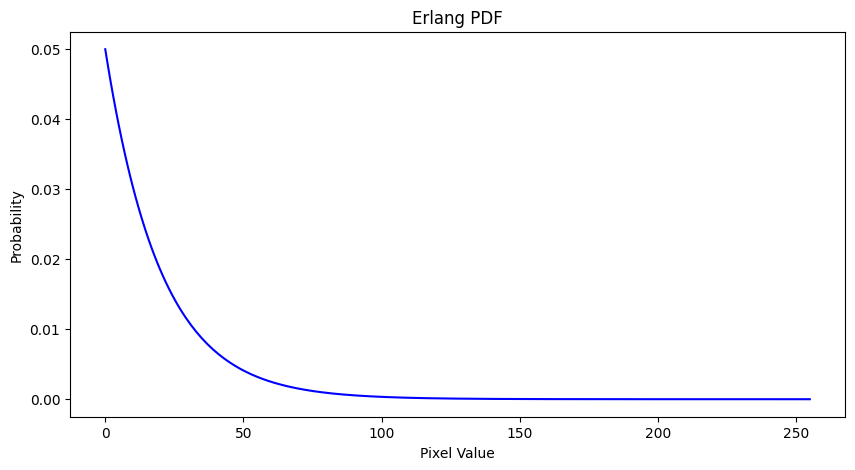

In [116]:
# Plot the erlang graph
plt.figure(figsize=(10,5))
plt.plot(erlang_pdf(1/20,1), color="blue")
plt.title("Erlang PDF")
plt.xlabel("Pixel Value")
plt.ylabel("Probability")
plt.show()

In [117]:
def build_mapping(input_cdf, target_cdf):
    """Build LUT mapping from input to target based on closest CDF values."""
    mapping = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        diff = np.abs(target_cdf - input_cdf[i])
        mapping[i] = np.argmin(diff)
    return mapping

In [118]:
def histogram_matching(image,landa,k):
  # Compute the histogram of the input image
  original_histogram = compute_histogram(image)
  total_pixels = image.shape[0] * image.shape[1]
  original_pdf = compute_pdf(original_histogram, total_pixels)
  
  original_cdf = compute_cdf(original_pdf)
  
  
  # Target PDF
  target_pdf = erlang_pdf(landa,k)
  target_cdf = compute_cdf(target_pdf)
  
  # Build mapping
  mapping = build_mapping(original_cdf, target_cdf)

    # Apply mapping
  matched_img = np.zeros_like(image)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        matched_img[i, j] = mapping[image[i, j]]

  return matched_img, target_pdf, target_cdf
  
  

In [119]:
original_image = cv2.imread('../../data/histogram.jpg',cv2.IMREAD_GRAYSCALE)
original_image_histogram = compute_histogram(original_image)
original_image_pdf = compute_pdf(original_image_histogram, original_image.shape[0] * original_image.shape[1])
original_image_cdf = compute_cdf(original_image_pdf)

matched_img, t_pdf, t_cdf = histogram_matching(original_image, landa=1/20, k=1)

# calculate the pdf of matched_image
matched_image_histogram = compute_histogram(matched_img)
matched_image_pdf = compute_pdf(matched_image_histogram, original_image.shape[0] * original_image.shape[1])
matched_image_cdf = compute_cdf(matched_image_pdf)

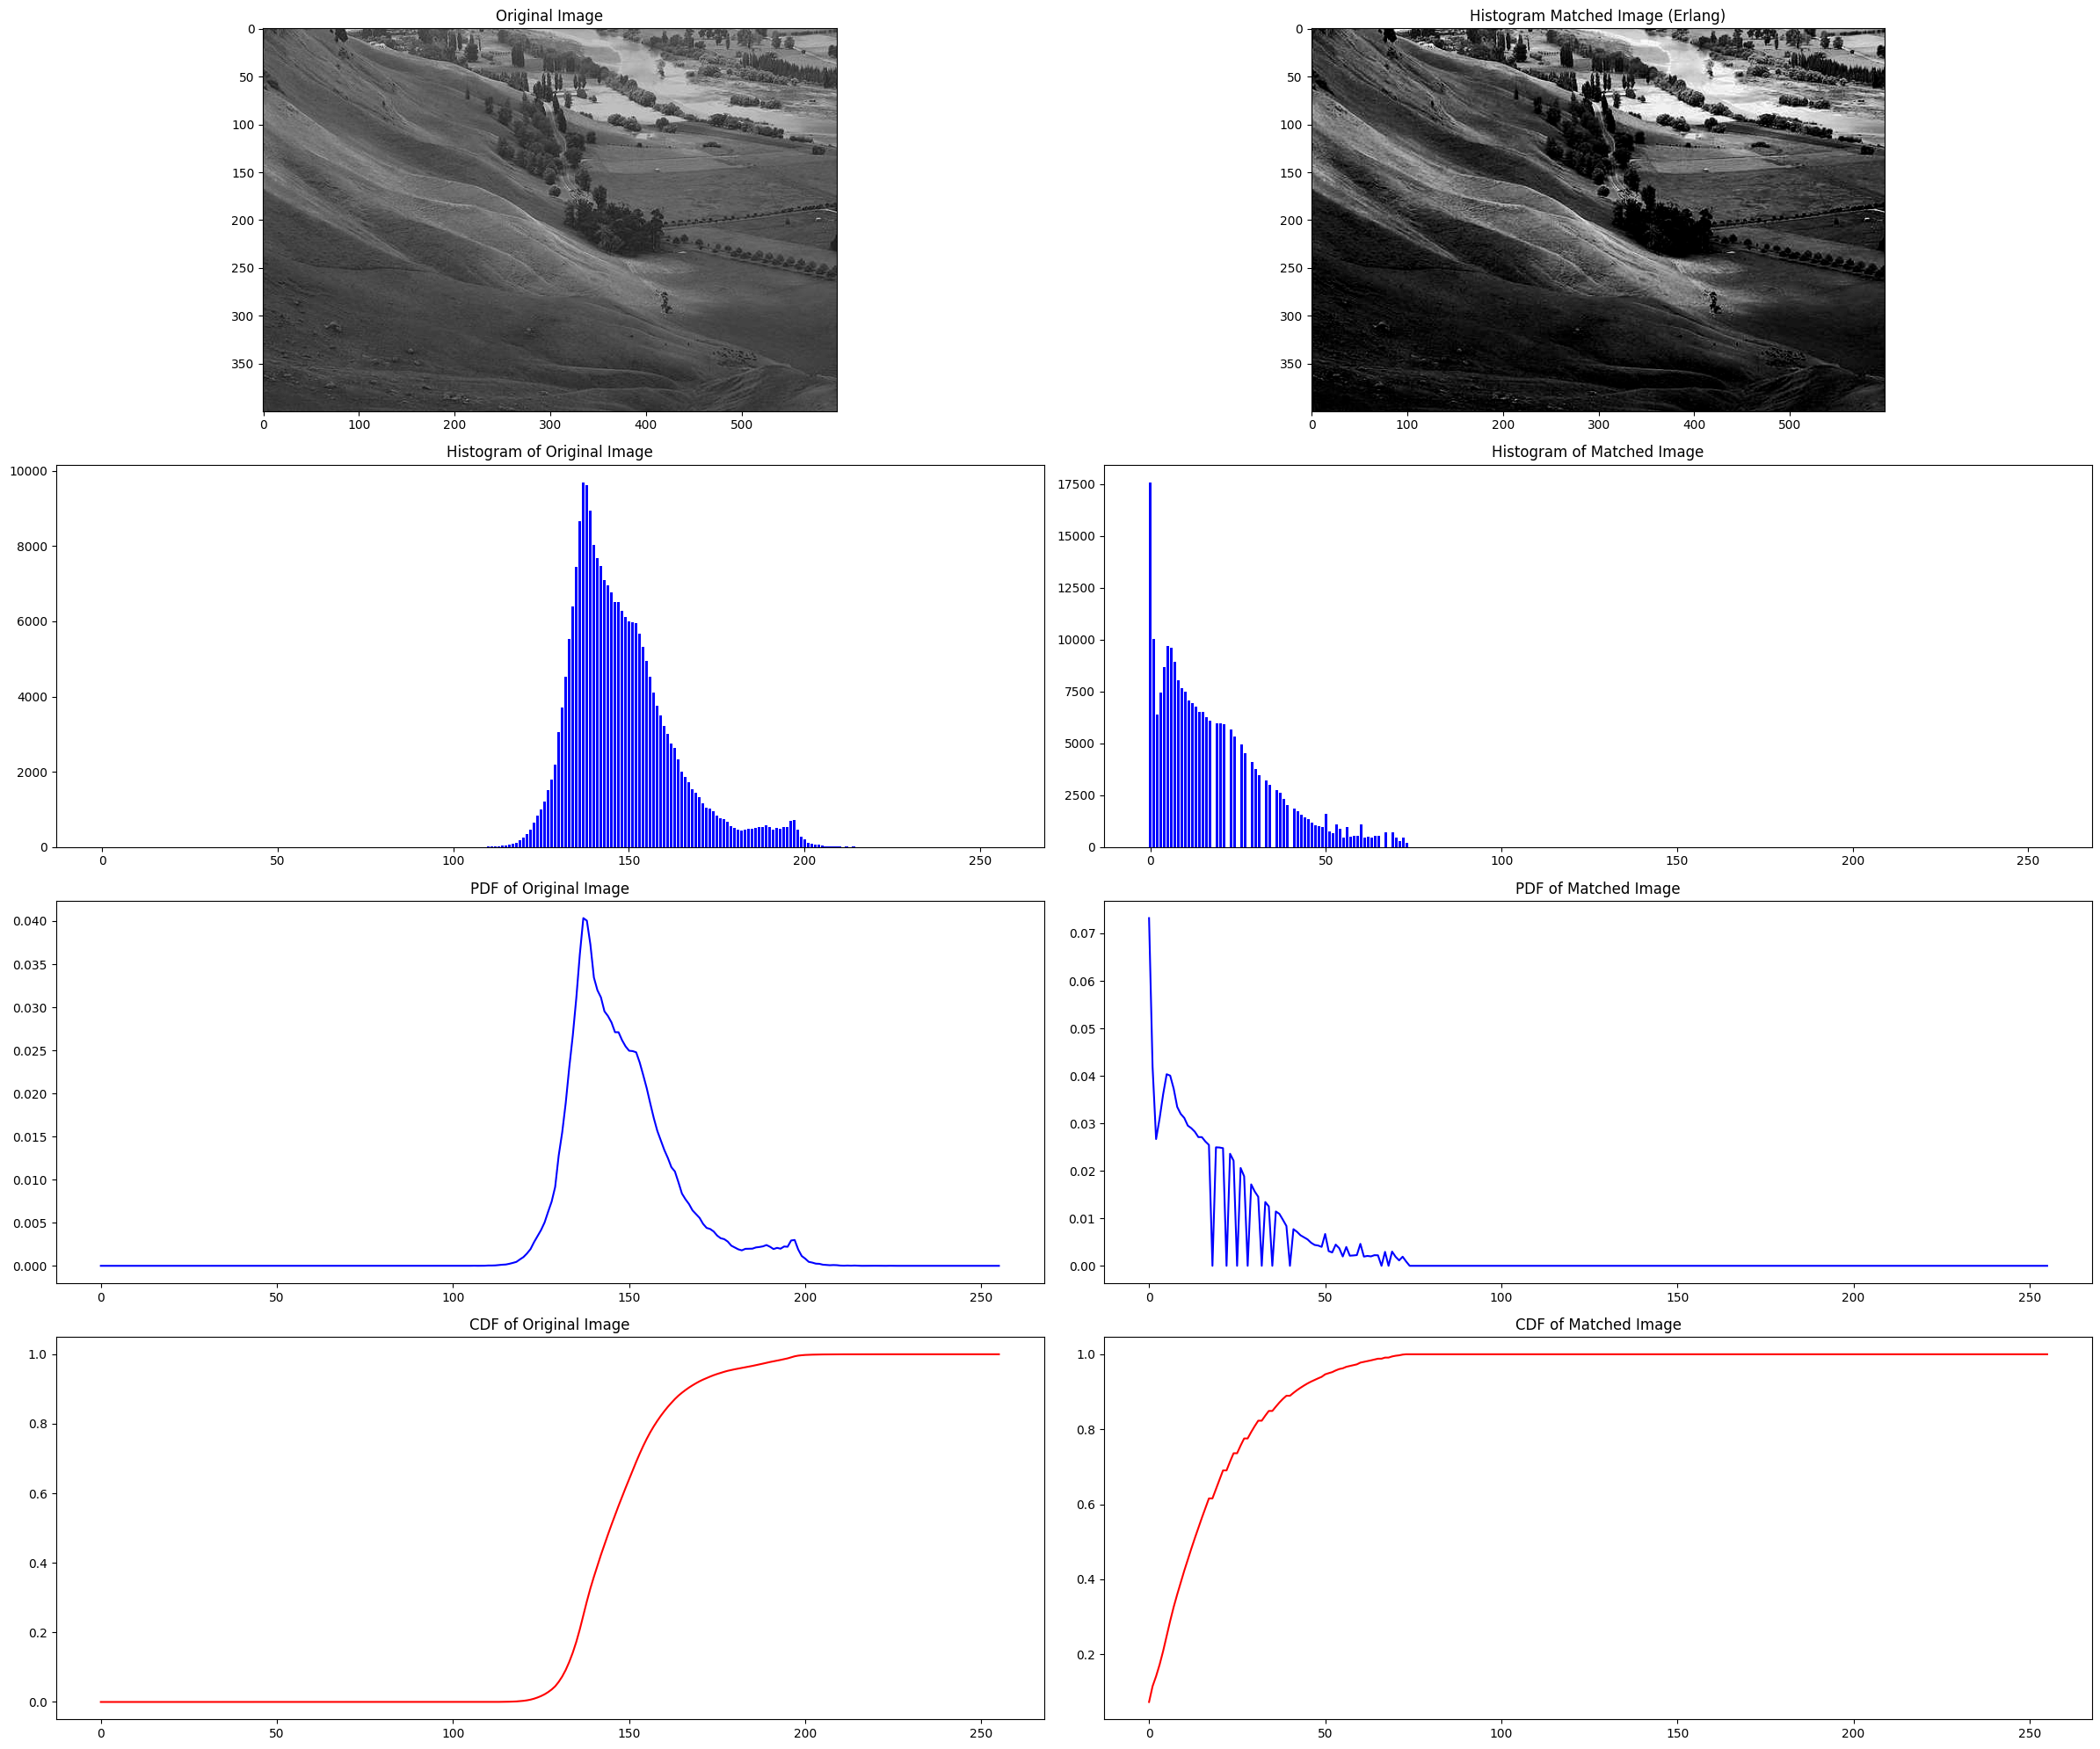

In [120]:
plt.figure(figsize=(24,20))

plt.subplot(4,2,1)
plt.imshow(original_image, cmap="gray")
plt.title("Original Image")

plt.subplot(4,2,2)
plt.imshow(matched_img, cmap="gray")
plt.title("Histogram Matched Image (Erlang)")

plt.subplot(4,2,3)
plt.bar(range(256), original_image_histogram, color="blue")
plt.title("Histogram of Original Image")

plt.subplot(4,2,4)
plt.bar(range(256), matched_image_histogram, color="blue")
plt.title("Histogram of Matched Image")

plt.subplot(4,2,5)
plt.plot(original_image_pdf, color="blue", label="Original PDF")
plt.title("PDF of Original Image")

plt.subplot(4,2,6)
plt.plot(matched_image_pdf, color="blue", label="Matched PDF")
plt.title("PDF of Matched Image")

plt.subplot(4,2,7)
plt.plot(original_image_cdf, color="red", label="Original CDF")
plt.title("CDF of Original Image")

plt.subplot(4,2,8)
plt.plot(matched_image_cdf, color="red", label="Matched CDF")
plt.title("CDF of Matched Image")

plt.tight_layout()
plt.show()